<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/XGBoost_Model_Motility_Biosignatures_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# logistic regression
from sklearn.linear_model import LogisticRegression

# decision tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier
import sklearn.metrics
from sklearn.metrics import accuracy_score, fbeta_score

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Data Loading and Processing


In [ ]:
# Purely for visulatization and reference
# train.json and test.json are not needed and not used for this code
# Import data
with open('/content/train.json', 'r') as f:
    train_data = json.load(f)

with open('/content/test.json', 'r') as f:
    test_data = json.load(f)

In [ ]:
len(test_data.keys())

11

## Preprocessing Features

In [ ]:
# Preprocessing
# Normalizes Data
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.mix())

In [ ]:
# copy the data
test_data = pd.read_csv('/content/test_features_20230215_001910.csv')
trained = pd.read_csv('/content/train_features_20230215_002012.csv')
display(trained)
print(trained)
display(test_data)
train_max_scaled = trained.copy()
test_max_scaled = test_data.copy()
  
# apply normalization techniques
# x - xmin / range; xmin is always 0
train_max_scaled['mean_step_speed'] = train_max_scaled['mean_step_speed'] / train_max_scaled['mean_step_speed'].max()
train_max_scaled['stddev_step_speed'] = train_max_scaled['stddev_step_speed']/train_max_scaled['stddev_step_speed'].abs().max()
train_max_scaled['track_length'] = train_max_scaled['track_length']/train_max_scaled['track_length'].abs().max()
train_max_scaled['e2e_distance'] = train_max_scaled['e2e_distance']/train_max_scaled['e2e_distance'].abs().max()
train_max_scaled['duration'] = train_max_scaled['duration']/train_max_scaled['duration'].abs().max()
train_max_scaled['angle_stddev'] = train_max_scaled['angle_stddev']/train_max_scaled['angle_stddev'].abs().max()
train_max_scaled['track_length_sliding_window_5'] = train_max_scaled['track_length_sliding_window_5']/train_max_scaled['track_length_sliding_window_5'].abs().max()

test_max_scaled['mean_step_speed'] = test_max_scaled['mean_step_speed']/test_max_scaled['mean_step_speed'].abs().max()
test_max_scaled['stddev_step_speed'] = test_max_scaled['stddev_step_speed']/test_max_scaled['stddev_step_speed'].abs().max()
test_max_scaled['track_length'] = test_max_scaled['track_length']/test_max_scaled['track_length'].abs().max()
test_max_scaled['e2e_distance'] = test_max_scaled['e2e_distance']/test_max_scaled['e2e_distance'].abs().max()
test_max_scaled['duration'] = test_max_scaled['duration']/test_max_scaled['duration'].abs().max()
test_max_scaled['angle_stddev'] = test_max_scaled['angle_stddev']/test_max_scaled['angle_stddev'].abs().max()
test_max_scaled['track_length_sliding_window_5'] = test_max_scaled['track_length_sliding_window_5']/test_max_scaled['track_length_sliding_window_5'].abs().max()

# Shuffles the rows of data 
trained_max_scaled = train_max_scaled.sample(frac=1).reset_index(drop=True)

display(train_max_scaled)

train_X = train_max_scaled.iloc[:, 2:]
train_Y = train_max_scaled.iloc[:, 1]
test_X = test_max_scaled.iloc[:, 2:]

#print(test_max_scaled)
# view normalized data
# display(train_max_scaled)
# display(test_max_scaled)

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,angle_stddev,track_length_sliding_window_5,progressivity,mean_signed_turning_angle
0,lab_0_0,0,0.173088,0.100141,51.926349,40.408772,300.0,2.222296,50.148130,1.285027,-0.004815
1,lab_0_1,0,0.165048,0.086194,49.514298,32.957322,300.0,2.326700,46.613296,1.502376,-0.000385
2,lab_0_2,0,0.167388,0.099177,50.216438,31.649486,300.0,2.388929,48.411317,1.586643,0.004118
3,lab_0_3,0,0.215927,0.109797,64.778077,42.524948,300.0,2.427271,61.750505,1.523296,0.008042
4,lab_0_4,0,0.097786,0.096984,29.335788,1.616936,300.0,1.975702,27.908952,18.142829,0.014407
...,...,...,...,...,...,...,...,...,...,...,...
16075,sim_419_59,0,1.531170,0.546807,176.084514,159.831161,115.0,0.484968,162.109853,1.101691,-0.012253
16076,sim_419_60,0,1.539173,0.526780,357.088240,328.124976,232.0,0.455669,327.795852,1.088269,-0.007705
16077,sim_419_61,0,1.532309,0.563054,306.461775,275.072718,200.0,0.509467,279.344781,1.114112,0.000953
16078,sim_419_62,0,1.446036,0.573567,144.603611,133.206606,100.0,0.479184,135.075761,1.085559,-0.008965


              uid  label  mean_step_speed  stddev_step_speed  track_length  \
0         lab_0_0      0         0.173088           0.100141     51.926349   
1         lab_0_1      0         0.165048           0.086194     49.514298   
2         lab_0_2      0         0.167388           0.099177     50.216438   
3         lab_0_3      0         0.215927           0.109797     64.778077   
4         lab_0_4      0         0.097786           0.096984     29.335788   
...           ...    ...              ...                ...           ...   
16075  sim_419_59      0         1.531170           0.546807    176.084514   
16076  sim_419_60      0         1.539173           0.526780    357.088240   
16077  sim_419_61      0         1.532309           0.563054    306.461775   
16078  sim_419_62      0         1.446036           0.573567    144.603611   
16079  sim_419_63      0         1.542175           0.604178    462.652414   

       e2e_distance  duration  angle_stddev  track_length_slidi

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,angle_stddev,track_length_sliding_window_5,progressivity,mean_signed_turning_angle
0,lab_0_0,0,0.173088,0.100141,51.926349,40.408772,300.0,2.222296,50.148130,1.285027,-0.004815
1,lab_0_1,0,0.165048,0.086194,49.514298,32.957322,300.0,2.326700,46.613296,1.502376,-0.000385
2,lab_0_2,0,0.167388,0.099177,50.216438,31.649486,300.0,2.388929,48.411317,1.586643,0.004118
3,lab_0_3,0,0.215927,0.109797,64.778077,42.524948,300.0,2.427271,61.750505,1.523296,0.008042
4,lab_0_4,0,0.097786,0.096984,29.335788,1.616936,300.0,1.975702,27.908952,18.142829,0.014407
...,...,...,...,...,...,...,...,...,...,...,...
16075,sim_419_59,0,1.531170,0.546807,176.084514,159.831161,115.0,0.484968,162.109853,1.101691,-0.012253
16076,sim_419_60,0,1.539173,0.526780,357.088240,328.124976,232.0,0.455669,327.795852,1.088269,-0.007705
16077,sim_419_61,0,1.532309,0.563054,306.461775,275.072718,200.0,0.509467,279.344781,1.114112,0.000953
16078,sim_419_62,0,1.446036,0.573567,144.603611,133.206606,100.0,0.479184,135.075761,1.085559,-0.008965


,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,angle_stddev,track_length_sliding_window_5,progressivity,mean_signed_turning_angle
0,lab_0_0,0,0.009109,0.002025,0.033693,0.033940,0.877193,0.790983,0.037266,1.285027,-0.004815
1,lab_0_1,0,0.008686,0.001743,0.032128,0.027681,0.877193,0.828143,0.034639,1.502376,-0.000385
2,lab_0_2,0,0.008809,0.002006,0.032584,0.026583,0.877193,0.850293,0.035975,1.586643,0.004118
3,lab_0_3,0,0.011363,0.002220,0.042033,0.035717,0.877193,0.863940,0.045887,1.523296,0.008042
4,lab_0_4,0,0.005146,0.001961,0.019035,0.001358,0.877193,0.703212,0.020739,18.142829,0.014407
...,...,...,...,...,...,...,...,...,...,...,...
16075,sim_419_59,0,0.080578,0.011058,0.114256,0.134245,0.336257,0.172615,0.120465,1.101691,-0.012253
16076,sim_419_60,0,0.080999,0.010653,0.231704,0.275597,0.678363,0.162186,0.243588,1.088269,-0.007705
16077,sim_419_61,0,0.080638,0.011387,0.198854,0.231038,0.584795,0.181335,0.207584,1.114112,0.000953
16078,sim_419_62,0,0.076098,0.011600,0.093829,0.111882,0.292398,0.170556,0.100376,1.085559,-0.008965


# Train Test Data Split (75 : 25)
Splits the training data into training and validation data via a 75 to 25 split.
We need to do this, so we have some correct data we can compare our model to that we don't train on since the test data doesn't actually come with labels.

In [ ]:
# Uses 75:25 split for training and testing data out of the training data
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X, train_Y, test_size = 0.25, random_state = 200)

# Helper Functions
Functions to Measure Accuracy and Make Classifier with Custom Hyperparameters 

In [ ]:
def compute_accuracy(predictions, labels, print_accuracy):
  total = len(labels)
  correct = sum(predictions == labels)
  accuracy = correct / total
  if (print_accuracy):
    print("Accuracy:", correct, "/", total, " = ", accuracy)
  return accuracy

In [ ]:
def make_tailored_XGB_classifier(validation=None):
  if (validation == None):
    return XGBClassifier(objective='binary:logistic', max_depth = 5) #max_depth=3, min_child_weight=1, 
  return XGBClassifier(objective='binary:logistic', eval_set=validation, max_depth = 5)

# Basic Model
Here, we train our tailored model on all the available training data.

No validation techniques used here. This model is also not what we used in our final submission. This was just for illustration purposes in deciding which model to choose. In our final submission, we implemented validation techniqies and considered more features.

In [ ]:
# Trained data

# WITHOUT HYPEROPT

# Fit model using XGB on training data
model = make_tailored_XGB_classifier()
model.fit(X_train_split, y_train_split)
print(model)

# Gets the predictions of the model given the training and testing input
train_predictions = model.predict(X_train_split)
test_predictions = model.predict(X_test_split)

# Calculates and computes accuracy
print("Training ", end="")
compute_accuracy(y_train_split, train_predictions, True)
print("Test ", end="")
compute_accuracy(y_test_split, test_predictions, True)
#print(accuracy_score(y_test_split, pred))

XGBClassifier(max_depth=5)
Training Accuracy: 12037 / 12060  =  0.9980928689883913
Test Accuracy: 3999 / 4020  =  0.994776119402985


# Hyperopt Hyperparameter Optimization

## Hyperopt Implementation
Here, hyperopt manipulates the hyperparameters of XGBClassifier and searches for the best hyperparameters for our data within the space we defined. It implements 3 search algorithms to scan the search space for optimal hyperparameters. We used this as an alternative to grid search.

In [ ]:
# RUN THIS FOR NOW WITHOUT HYPEROPT

# trying different hyperparameters here
space = {"max_depth": hp.quniform("max_depth", 3, 6, 1), "gamma": hp.uniform("gamma", 1, 20), 
         "reg_alpha": hp.quniform('reg_alpha', 40, 200, 1), "reg_lambda": hp.uniform("reg_lambda", 0, 2), 
         "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1), 
         "min_child_weight": hp.quniform("min_child_weight", 0, 14, 1), "n_estimators": 100, "seed": 0}

def objective(space):
  model = XGBClassifier(n_estimators = int(space["n_estimators"]), max_depth = int(space["max_depth"]), 
                        gamma = int(space["gamma"]), reg_alpha = int(space["reg_alpha"]), 
                        min_child_weight = int(space['min_child_weight']), 
                        colsample_bytree = int(space["colsample_bytree"]), objective="binary:logistic")
  evaluation = [(X_test_split, y_test_split)]
  model.fit(X_train_split, y_train_split, eval_set = evaluation, verbose=False, eval_metric = "error", early_stopping_rounds = 10)
  pred = model.predict(X_test_split)
  accuracy = accuracy_score(y_test_split, pred)
  print("Score: ", accuracy)
  return {'loss': -accuracy, 'status': STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)
print(best_hyperparams)

Score: 
0.9778606965174129
Score: 
0.982089552238806
Score: 
0.9778606965174129
Score: 
0.9768656716417911
Score: 
0.977363184079602
Score: 
0.9815920398009951
Score: 
0.982089552238806
Score: 
0.9815920398009951
Score: 
0.977363184079602
Score: 
0.9768656716417911
Score: 
0.9778606965174129
Score: 
0.982089552238806
Score: 
0.9768656716417911
Score: 
0.9818407960199005
Score: 
0.9778606965174129
Score: 
0.982089552238806
Score: 
0.9783582089552239
Score: 
0.977363184079602
Score: 
0.9818407960199005
Score: 
0.977363184079602
Score: 
0.9823383084577114
Score: 
0.9825870646766169
Score: 
0.9825870646766169
Score: 
0.9825870646766169
Score: 
0.9825870646766169
Score: 
0.9825870646766169
Score: 
0.9768656716417911
Score: 
0.9823383084577114
Score: 
0.9825870646766169
Score: 
0.9825870646766169
Score: 
0.9768656716417911
Score: 
0.9825870646766169
Score: 
0.9823383084577114
Score: 
0.9823383084577114
Score: 
0.9825870646766169
Score: 
0.9823383084577114
Score: 
0.9825870646766169
Score: 
0

In [ ]:
curr_params = best_hyperparams
print(curr_params)

{'colsample_bytree': 0.8033352067300492, 'gamma': 1.7755099634012046, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_alpha': 175.0, 'reg_lambda': 1.311394154103208}


In [ ]:
old_params = best_hyperparams
print(best_hyperparams)

{'colsample_bytree': 0.8505360910159591, 'gamma': 3.1943316028884015, 'max_depth': 5.0, 'min_child_weight': 1.0, 'reg_alpha': 196.0, 'reg_lambda': 0.9862714329814055}


## Run the code with the hyperparameters calculated by hyperopt

In [ ]:
# CODE WITH HYPEROPT

# Fit model using XGB on training data
model = XGBClassifier(colsample_bytree=best_hyperparams["colsample_bytree"], gamma = best_hyperparams["gamma"], 
                      max_depth = int(best_hyperparams["max_depth"]), min_child_weight=best_hyperparams["min_child_weight"],
                      reg_alpha = best_hyperparams["reg_alpha"], objective="binary:logistic")
print(model)
model.fit(train_X, train_Y)
y_pred = model.predict(test_X)

# DID NOT WORK - ENDED UP OVERFITTING DATA

XGBClassifier(colsample_bytree=0.6674248090113143, gamma=14.959280539759963,
              min_child_weight=7.0, reg_alpha=165.0)


## Takeaways

Despite our attempts, the hyperparameters generated by HyperOpt ended up overfitting the data. The models it produced outputted high accuracy and low loss on the training data but suboptimal performance when predicting the test data. We believe this is because the distribution of the test data is different than the distribution of our training data. In order to confirm this, we would have to do more analysis on the data, and we would have done so, if we had more time.

# Validation


Develops helper functions for building validation supported models

In [ ]:
# K-Fold Cross Validation 
'''
Does Cross K Fold Validation and 
returns the list of the K generated models

Note: Assumes data is already shuffled.
'''
def k_fold_validation(num_folds, data_X, data_Y, print_output=False):
  # Saves training and testing accuracies
  train_accuracies = np.zeros(num_folds)
  test_accuracies = np.zeros(num_folds)

  # Saves models
  models = []

  # Splits data set into k partitions
  kf = KFold(n_splits=num_folds)

  # Iterates through cross-validation folds:
  run_count = 0
  for train_indices, test_indices in kf.split(data_X):
    # Training and testing data points for this fold
    x_fold_train, x_fold_test = data_X.iloc[train_indices, :], data_X.iloc[test_indices, :]
    y_fold_train, y_fold_test = data_Y.iloc[train_indices], data_Y.iloc[test_indices]

    # Fits a model to the training data
    model = make_tailored_XGB_classifier([(x_fold_train, y_fold_train), (x_fold_test, y_fold_test)])
    model.fit(x_fold_train, y_fold_train, eval_metric='logloss')
    models.append(model)

    # Computes the training and test error for this fold
    if print_output:
      print("Train", end = " ")
    fold_train_accuracy = compute_accuracy(y_fold_train, model.predict(x_fold_train), print_output)
    train_accuracies[run_count] = fold_train_accuracy
    if print_output:
      print("Test", end = " ")
    fold_test_accuracy = compute_accuracy(y_fold_test, model.predict(x_fold_test), print_output)
    test_accuracies[run_count] = fold_test_accuracy
    pred = model.predict(x_fold_test)
    F1score = sklearn.metrics.fbeta_score(y_true = y_fold_test, y_pred = pred, beta=1)
    if print_output:
      print("F1 Score:", F1score)

    run_count += 1

  return models

In [ ]:
'''
Given the k generated models and the test data, 
averages the predictions of all the models and outputs 
a list of those predictions
'''
def k_model_predict(k_models, test_X):
  num_models = len(k_models)

  model_predictions = []
  for model in k_models:
    y_pred = model.predict(test_X)
    model_predictions.append([round(value) for value in y_pred])

  averaged_predictions = []
  N = len(model_predictions[0])
  for i in range(N):
    row_prediction = 0
    for j in range(num_models):
      row_prediction += model_predictions[j][i]
    row_prediction = round((1.0 * row_prediction / num_models))
    averaged_predictions.append(row_prediction)
  return averaged_predictions

## Finds the Optimal K for K-Fold Cross Validation

Optimal K = 5

In [ ]:
# Compares models for different K
folds = [*range(3, 12)]
accuracies = []
f2_scores = []
for k in folds:
  k_models = k_fold_validation(k, X_train_split, y_train_split)
  y_test_pred = k_model_predict(k_models, X_test_split)
  print(k, "folds:")
  print("\tTest", end=" ")
  accuracy = compute_accuracy(y_test_pred, y_test_split, True)
  f2_score = fbeta_score(y_test_split, y_test_pred, beta=2)
  print("\tF2 Score:", f2_score)
  accuracies.append(accuracy)
  f2_scores.append(f2_score)

3 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965
4 folds:
	Test Accuracy: 3999 / 4020  =  0.994776119402985
	F2 Score: 0.9966993398679735
5 folds:
	Test Accuracy: 3999 / 4020  =  0.994776119402985
	F2 Score: 0.9966993398679735
6 folds:
	Test Accuracy: 3999 / 4020  =  0.994776119402985
	F2 Score: 0.9966993398679735
7 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965
8 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965
9 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965
10 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965
11 folds:
	Test Accuracy: 3998 / 4020  =  0.9945273631840796
	F2 Score: 0.9965996599659965


Generates the graph that demonstrates the difference in prediction performance with different K folds.

---



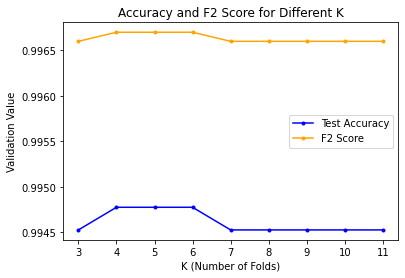

In [ ]:
# Plots the curve displaying the test accuracy and f2 score for different k
plt.figure() 

plt.plot(folds, accuracies, marker = '.', color = "blue") 
plt.plot(folds, f2_scores, marker = '.', color = "orange") 

# Labels the figure
plt.legend(['Test Accuracy', 'F2 Score'], loc = 'best')
plt.xlabel('K (Number of Folds)')
plt.ylabel('Validation Value')
plt.title('Accuracy and F2 Score for Different K')

plt.show()

# Takeaways

From the graph above, we see the model predicts and performs better with 5 folds. 

So, going forward, we choose 5 Fold Cross Validation in developing our Validation Model.

## Validation Model Predictions
Averages the predictions of the models trained from 5-Fold Validation to get the final submitted predictions of the test data. 

Averaging the predictions of the 5 models generated from 5-Fold Cross Validation resulted in higher accuracy.

In [ ]:
five_fold_models = k_fold_validation(5, train_X, train_Y)
averaged_predictions = k_model_predict(five_fold_models, test_X)

pred_df_avg = pd.DataFrame(columns = ['UID', 'label'])
pred_df_avg['UID'] = list(test_max_scaled['uid'])
pred_df_avg['label'] = averaged_predictions

This should create the csv of the averaged prdictions.

In [ ]:
pred_df_avg.to_csv('/content/submission9.csv', index=False)

## Generate Test Predictions for Regular Fully Trained Models

In [ ]:
# Test data

# Make predictions for test data
y_pred = model.predict(test_data.iloc[:, 2:])
predictions = [round(value) for value in y_pred]

pred_df = pd.DataFrame(columns = ['UID', 'label'])
pred_df['UID'] = list(test_max_scaled['uid'])
pred_df['label'] = predictions

print(test_data)
# display(pred_df)

              uid  label  mean_step_speed  stddev_step_speed  track_length  \
0         lab_0_0      0         0.173088           0.100141     51.926349   
1         lab_0_1      0         0.165048           0.086194     49.514298   
2         lab_0_2      0         0.167388           0.099177     50.216438   
3         lab_0_3      0         0.215927           0.109797     64.778077   
4         lab_0_4      0         0.097786           0.096984     29.335788   
...           ...    ...              ...                ...           ...   
16075  sim_419_59      0         1.531170           0.546807    176.084514   
16076  sim_419_60      0         1.539173           0.526780    357.088240   
16077  sim_419_61      0         1.532309           0.563054    306.461775   
16078  sim_419_62      0         1.446036           0.573567    144.603611   
16079  sim_419_63      0         1.542175           0.604178    462.652414   

       e2e_distance  duration  angle_stddev  track_length_slidi

In [ ]:
pred_df.to_csv('/content/submission8.csv', index=False)

Prints predictions

In [ ]:
pred_df

,UID,label
0,lab_19_0,0
1,lab_19_1,1
2,lab_19_2,1
3,lab_19_3,1
4,lab_19_4,1
...,...,...
472,lab_42_9,1
473,lab_42_10,1
474,lab_42_11,1
475,lab_42_12,0
